# Figure S5: Robustness to perturbations

In [1]:
import numpy as np
from scipy.stats import kurtosis
import matplotlib.pyplot as plt
import matplotlib.gridspec as gs
import h5py

import EIANN as eiann
import EIANN.utils as ut
from EIANN.generate_figures import *
eiann.update_plot_defaults()

In [2]:
figure_name = "FigS5_robustness_to_perturbations"
model_list = ["vanBP", "bpDale_fixed", "HebbWN_topsup", "bpLike_WT_hebbdend"]
model_dict_all = load_model_dict()
generate_hdf5_all_seeds(model_list, model_dict_all, variables_to_save = ['weights', 'noise_sensitivity', 'robustness_to_pruning'], recompute=None)

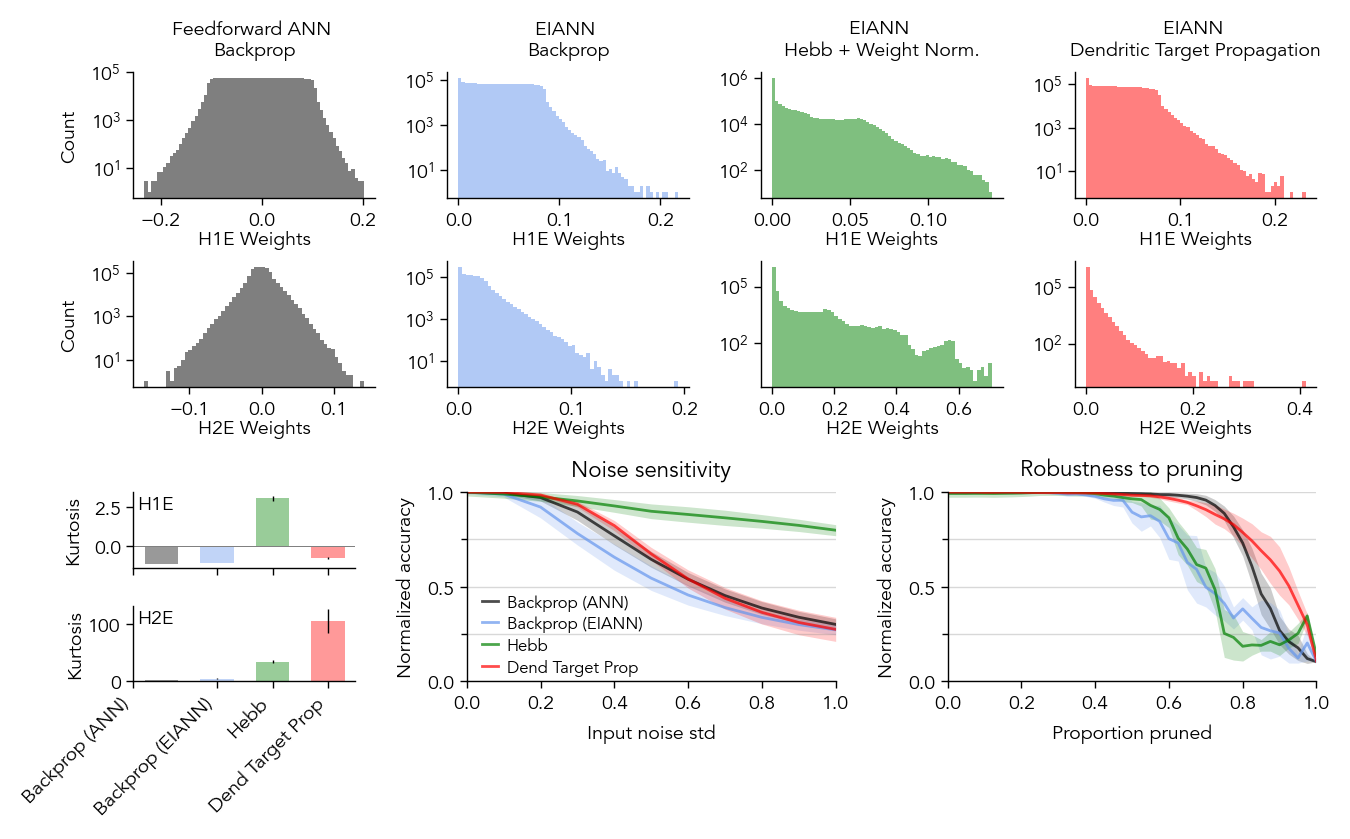

In [6]:
fig = plt.figure(figsize=(6.5, 3.5))
axes = gs.GridSpec(nrows=2, ncols=4, figure=fig,                    
                    left=0.07,right=0.98,
                    top=0.95, bottom=0.5,
                    wspace=0.3, hspace=0.5)

axes_perturbations = gs.GridSpec(nrows=2, ncols=3, figure=fig,                    
                    left=0.07,right=0.98,
                    top=0.35, bottom=0.08,
                    wspace=0.35, hspace=0.5, width_ratios=[0.6, 1, 1])
ax_kurtosisH1E = fig.add_subplot(axes_perturbations[0, 0])
ax_kurtosisH2E = fig.add_subplot(axes_perturbations[1, 0])
ax_noise = fig.add_subplot(axes_perturbations[:, 1]) 
ax_pruning = fig.add_subplot(axes_perturbations[:, 2])

root_dir = ut.get_project_root()

model_dict_all["vanBP"]["display_name"] = "Feedforward ANN \nBackprop"
model_dict_all["bpLike_WT_hebbdend"]["display_name"] = "EIANN \nDendritic Target Propagation"
model_dict_all["bpDale_fixed"]["display_name"] = "EIANN \nBackprop"
model_dict_all["HebbWN_topsup"]["display_name"] = "EIANN \nHebb + Weight Norm."

model_dict_all["vanBP"]["label"] = "Backprop (ANN)"
model_dict_all["bpLike_WT_hebbdend"]["label"] = "Dend Target Prop"
model_dict_all["bpDale_fixed"]["label"] = "Backprop (EIANN)"
model_dict_all["HebbWN_topsup"]["label"] = "Hebb"

for col, model_key in enumerate(model_list):
    model_dict = model_dict_all[model_key]
    network_name = model_dict['config'].split('.')[0]
    hdf5_path = root_dir + f"/EIANN/data/model_hdf5_plot_data/plot_data_{network_name}.h5"
    with h5py.File(hdf5_path, 'r') as f:
        data_dict = f[network_name]
        # print(f"Generating plots for {model_dict['label']}")

        #########################
        # Weight distributions
        #########################
        H1E_weights = []
        H2E_weights = []
        for seed in model_dict['seeds']:
            H1E_weights.extend(data_dict[seed]['weights']['final_weights']['H1E_InputE'][:].flatten())
            H2E_weights.extend(data_dict[seed]['weights']['final_weights']['H2E_H1E'][:].flatten())

        ax = fig.add_subplot(axes[0, col])
        ax.hist(H1E_weights, bins=70, alpha=0.5, color=model_dict["color"], density=False)
        ax.set_xlabel("H1E Weights", labelpad=0)
        if col == 0:
            ax.set_ylabel("Count")
        ax.set_title(model_dict['display_name'])
        ax.set_yscale('log')

        ax = fig.add_subplot(axes[1, col])
        ax.hist(H2E_weights, bins=60, alpha=0.5, color=model_dict["color"], density=False)        
        ax.set_xlabel("H2E Weights", labelpad=0)
        if col == 0:
            ax.set_ylabel("Count")
        ax.set_yscale('log')

        projection = 'H1E_InputE'
        plot_kurtosis_all_seeds(data_dict, model_dict, projection, ax=ax_kurtosisH1E)
        projection = 'H2E_H1E'
        plot_kurtosis_all_seeds(data_dict, model_dict, projection, ax=ax_kurtosisH2E)

        ###############################
        # Robustness to input noise
        ###############################
        accuracy_list = []
        for seed in model_dict['seeds']:
            noise_stds, noise_accuracy = data_dict[seed]['noise_sensitivity']
            accuracy_list.append(noise_accuracy)
        accuracy_array = np.array(accuracy_list)
        mean_accuracy = np.mean(accuracy_array, axis=0)
        mean_accuracy_norm = mean_accuracy / np.max(mean_accuracy)
        std_accuracy_norm = np.std(accuracy_array, axis=0) / np.max(mean_accuracy)
        ax_noise.plot(noise_stds, mean_accuracy_norm, label=model_dict['label'], linewidth=1, color=model_dict["color"], alpha=0.7)
        ax_noise.fill_between(noise_stds, mean_accuracy_norm - std_accuracy_norm, mean_accuracy_norm + std_accuracy_norm, alpha=0.2, color=model_dict["color"], linewidth=0.) 
        ax_noise.set_xlim([0, 1])
        ax_noise.set_ylim([0, 1])
        ax_noise.set_yticks([0, 0.5, 1], minor=False)
        ax_noise.set_yticks(np.linspace(0, 1, 5), minor=True)
        ax_noise.legend(frameon=False, fontsize=6, loc='lower left', bbox_to_anchor=(0., -0.05))
        ax_noise.grid(True, axis='y', color='gray', linewidth=0.5, alpha=0.3, which='both')
        ax_noise.set_xlabel("Input noise std")
        ax_noise.set_ylabel("Normalized accuracy")
        ax_noise.set_title("Noise sensitivity", fontsize=8)

        ##################################
        # Robustness to synaptic pruning
        ##################################
        accuracy_list = []
        for seed in model_dict['seeds']:
            fraction_to_prune, accuracy = data_dict[seed]['robustness_to_pruning']
            accuracy_list.append(accuracy)
        accuracy_array = np.array(accuracy_list)
        mean_accuracy = np.mean(accuracy_array, axis=0)
        mean_accuracy_norm = mean_accuracy / np.max(mean_accuracy)
        std_accuracy_norm = np.std(accuracy_array, axis=0) / np.max(mean_accuracy)
        ax_pruning.plot(fraction_to_prune, mean_accuracy_norm, label=model_key, linewidth=1, color=model_dict["color"], alpha=0.7)
        ax_pruning.fill_between(fraction_to_prune, mean_accuracy_norm - std_accuracy_norm, mean_accuracy_norm + std_accuracy_norm, alpha=0.2, color=model_dict["color"], linewidth=0.) 
        ax_pruning.set_xlim([0, 1])
        ax_pruning.set_ylim([0, 1])
        ax_pruning.set_yticks([0, 0.5, 1], minor=False)
        ax_pruning.set_yticks(np.linspace(0, 1, 5), minor=True)
        ax_pruning.grid(True, axis='y', color='gray', linewidth=0.5, alpha=0.3, which='both')
        ax_pruning.set_xlabel("Proportion pruned")
        ax_pruning.set_ylabel("Normalized accuracy")
        ax_pruning.set_title("Robustness to pruning", fontsize=8)

ax_kurtosisH1E.set_ylabel("Kurtosis")
ax_kurtosisH2E.set_ylabel("Kurtosis", labelpad=1)
ax_kurtosisH1E.set_title("H1E", x=0.1, y=0.55)
ax_kurtosisH2E.set_title("H2E", x=0.1, y=0.55)
ax_kurtosisH1E.set_xticklabels([])

plt.show()

fig.savefig(f"{root_dir}/EIANN/figures/{figure_name}.svg", dpi=300)
fig.savefig(f"{root_dir}/EIANN/figures/{figure_name}.png", dpi=300)